# Аффективная поляризация

In [ ]:
!pip install -q ruptures bertopic sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 44.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import re
from datetime import datetime, timedelta
from dateutil import parser
from collections import Counter
from tqdm import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from wordcloud import WordCloud
from pandas.plotting import autocorrelation_plot

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, grangercausalitytests, arma_order_select_ic
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.api import VAR

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import silhouette_score

from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from cuml.manifold import UMAP as cuUMAP
from hdbscan import HDBSCAN

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
sns.set_theme(style="whitegrid")

In [ ]:
from google.colab import drive; drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
folder = '/content/drive/MyDrive/polarization_data/'

In [ ]:
df_tweets = pd.read_csv(folder + 'dataset.csv')
df_tweets.head()

,number,link,text,user,likes,quotes,retweets,comments,label,cleaned_text
0,1,https://twitter.com/BabylonBulletin/status/171...,🚨 #BREAKING 🚨 A high-ranking member of Israe...,Babylon Bulletin,2,0,0,0,0,breaking highranking member israeli special fo...
1,780,https://twitter.com/bahabreaking/status/178496...,Hamas: No ceasefire if Israel fails to meet de...,baha,0,0,0,0,0,hamas ceasefire israel fails meet demands hama...
2,781,https://twitter.com/ttimagazine/status/1784966...,Hamas Says ‘No Major Issues’ With Israeli Ceas...,The Truth International,0,0,0,0,0,hamas says major issues israeli ceasefire prop...
3,782,https://twitter.com/leapp77/status/17849657885...,UK PM urges Hamas to accept 40-day #ceasefire ...,Fa. pan,0,0,0,0,0,uk pm urges hamas accept 40day ceasefire hamas...
4,784,https://twitter.com/LeilaniAthenai1/status/178...,"It's not about #Zionism VS pro-#Palestine, but...",Leilani Athenaire,8,2,10,2,0,zionism vs propalestine antiwar antihate antig...


Достаем дату из твита, исходя из snowflake подхода

In [ ]:
TWITTER_EPOCH = 1288834974657

def extract_tweet_id(url: str) -> int:
    match = re.search(r'/status/(\d+)', url)
    if not match:
        raise ValueError(f"Не удалось извлечь ID из {url}")
    return int(match.group(1))

def snowflake_to_datetime(tweet_id: int, tz_offset_hours: int = 3) -> datetime:
    timestamp_ms = (tweet_id >> 22) + TWITTER_EPOCH
    dt_utc = datetime.utcfromtimestamp(timestamp_ms / 1000.0)
    return dt_utc + timedelta(hours=tz_offset_hours)

df_tweets['id'] = df_tweets['link'].apply(extract_tweet_id)
df_tweets['datetime'] = df_tweets['id'].apply(lambda tid: snowflake_to_datetime(tid, tz_offset_hours=3))

## EDA

In [ ]:
df_tweets.isna().sum()

,0
number,0
link,0
text,0
user,1
likes,0
quotes,0
retweets,0
comments,0
label,0
cleaned_text,1


In [ ]:
df_tweets.dropna(inplace=True)

In [ ]:
df_tweets.describe()

,number,likes,quotes,retweets,comments,label,id,datetime
count,7321.000000,7321.000000,7321.000000,7321.000000,7321.000000,7321.000000,7.321000e+03,7321
mean,568.668625,10.734599,0.346811,4.530938,1.308018,1.736785,1.772037e+18,2024-03-25 02:04:42.563927040
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.717508e+18,2023-10-26 14:46:57.435000
25%,285.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.745223e+18,2024-01-11 02:16:38.264000
50%,561.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.774576e+18,2024-04-01 02:14:00.364999936
75%,842.000000,1.000000,0.000000,0.000000,0.000000,2.000000,1.803538e+18,2024-06-20 00:18:47.752999936
max,1276.000000,9025.000000,343.000000,4028.000000,1256.000000,5.000000,1.835469e+18,2024-09-16 02:59:57.529000
std,332.698379,140.025835,5.719902,63.981977,20.697649,1.530643,3.300693e+16,NaN


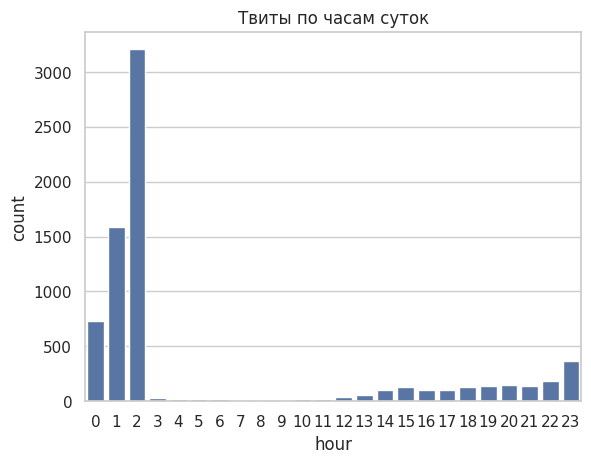

In [ ]:
df_tweets["hour"] = df_tweets["datetime"].dt.hour
sns.countplot(x="hour", data=df_tweets)
plt.title("Твиты по часам суток")
plt.show()

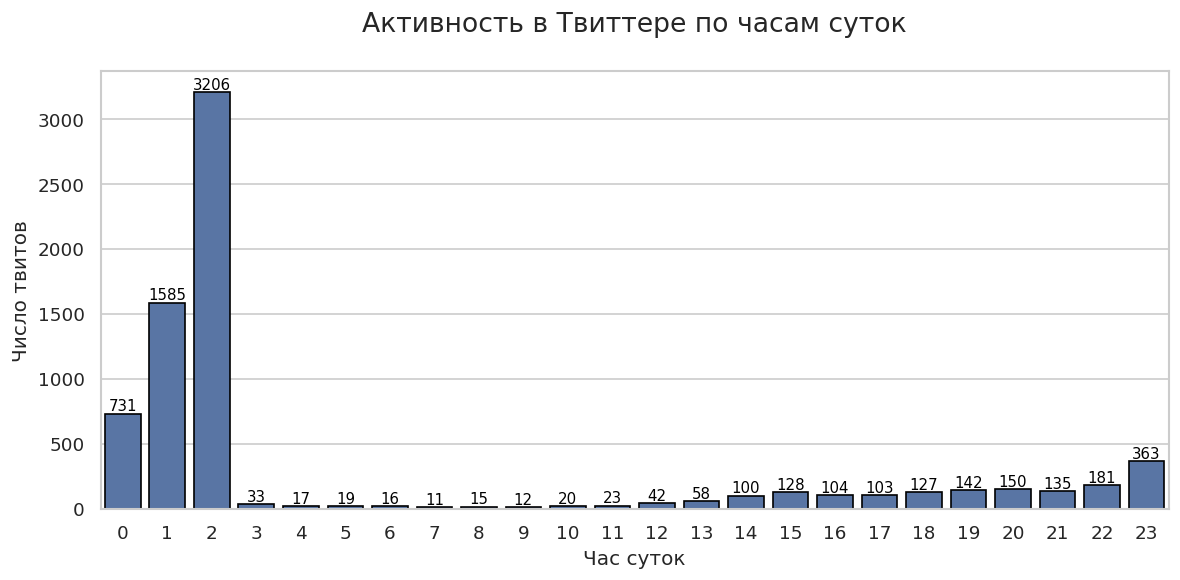

In [ ]:
hourly_counts = df_tweets["hour"].value_counts().sort_index()

plt.figure(figsize=(10, 5), dpi=120)


ax = sns.barplot(
    x=hourly_counts.index,
    y=hourly_counts.values,
    edgecolor='black'
)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f"{int(height)}",
        (p.get_x() + p.get_width() / 2, height),
        ha='center',
        va='bottom',
        fontsize=9,
        color='black'
    )

ax.set_title("Активность в Твиттере по часам суток\n", fontsize=16)
ax.set_xlabel("Час суток", fontsize=12)
ax.set_ylabel("Число твитов", fontsize=12)
ax.set_xticklabels([str(h) for h in hourly_counts.index], rotation=0)

plt.tight_layout()
plt.show()

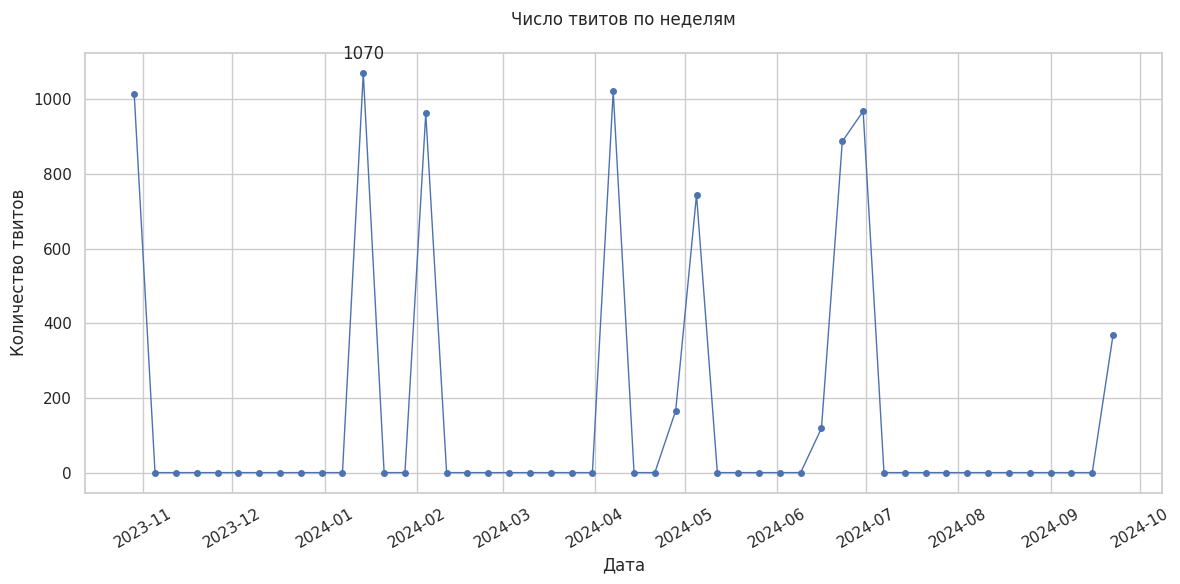

In [ ]:
weekly_counts = (
    df_tweets
    .set_index("datetime")["id"]
    .resample("W")
    .count()
)

max_date = weekly_counts.idxmax()
max_value = weekly_counts.max()

plt.figure(figsize=(12, 6))
plt.plot(
    weekly_counts.index,
    weekly_counts.values,
    marker='o',
    linestyle='-',
    linewidth=1,
    markersize=4
)

plt.annotate(
    f'{max_value}',
    xy=(max_date, max_value),
    xytext=(0, 10),
    textcoords='offset points',
    ha='center'
)

plt.title("Число твитов по неделям\n")
plt.ylabel("Количество твитов")
plt.xlabel("Дата")
plt.xticks(rotation=30)

plt.tight_layout()
plt.show()

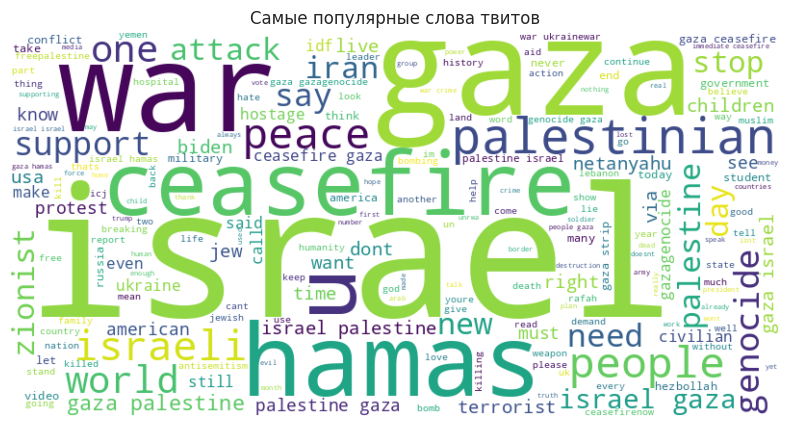

In [ ]:
all_text = " ".join(df_tweets["cleaned_text"].dropna())
wc = WordCloud(width=800,
               height=400,
               # random_state=42,
               background_color="white").generate(all_text)
plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Самые популярные слова твитов")
plt.show()

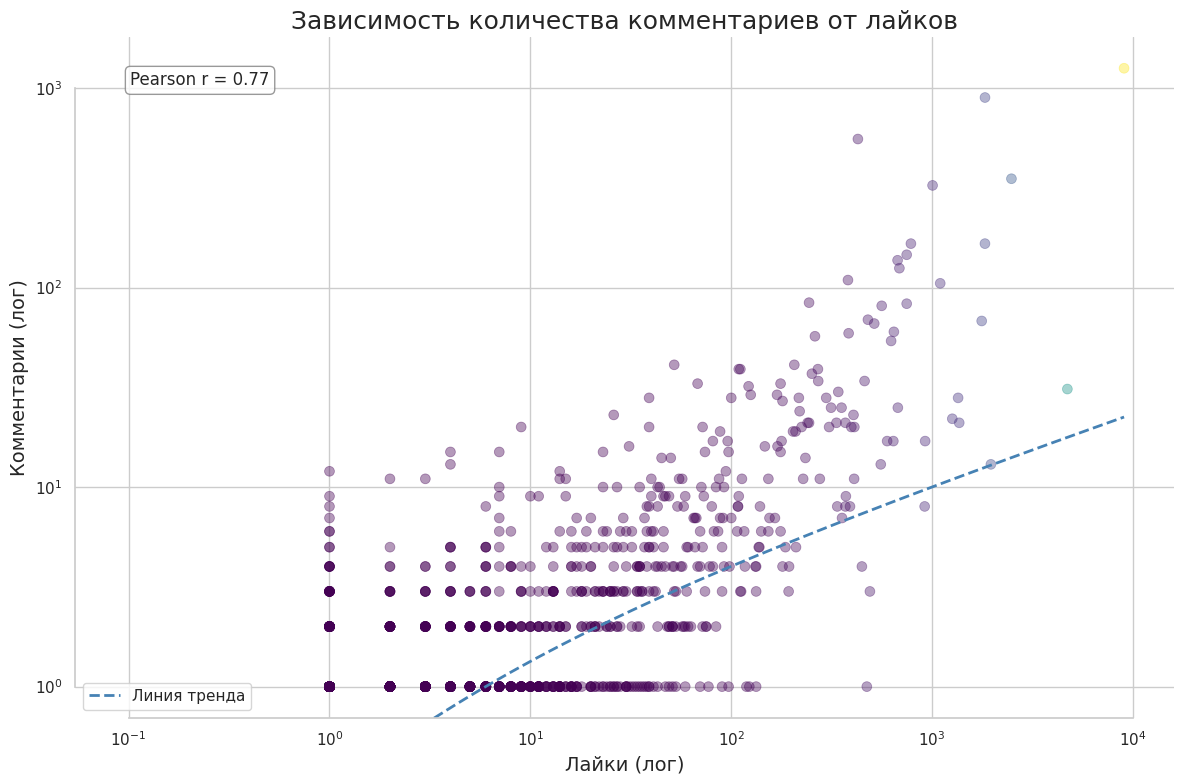

In [ ]:
plt.figure(figsize=(12, 8))

points = sns.scatterplot(
    x="likes",
    y="comments",
    data=df_tweets,
    alpha=0.4,
    edgecolor=None,
    hue="likes",
    palette="viridis",
    legend=False,
    s=50
)

points.set(xscale="log", yscale="log")
points.set_xlabel("Лайки (лог)", fontsize=14)
points.set_ylabel("Комментарии (лог)", fontsize=14)
points.set_title("Зависимость количества комментариев от лайков", fontsize=18)
points.set_ylim(bottom=-10)

x = np.log1p(df_tweets["likes"])
y = np.log1p(df_tweets["comments"])
coef = np.polyfit(x, y, 1)
poly1d_fn = np.poly1d(coef)
xs = np.linspace(x.min(), x.max(), 100)
plt.plot(np.expm1(xs), np.expm1(poly1d_fn(xs)),
         color="steelblue", linestyle="--", linewidth=2, label="Линия тренда")

corr = df_tweets[["likes","comments"]].corr().iloc[0,1]
plt.text(
    0.05, 0.95,
    f"Pearson r = {corr:.2f}",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top',
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray", alpha=0.8)
)

sns.despine(trim=True)

plt.legend()
plt.tight_layout()
plt.show()

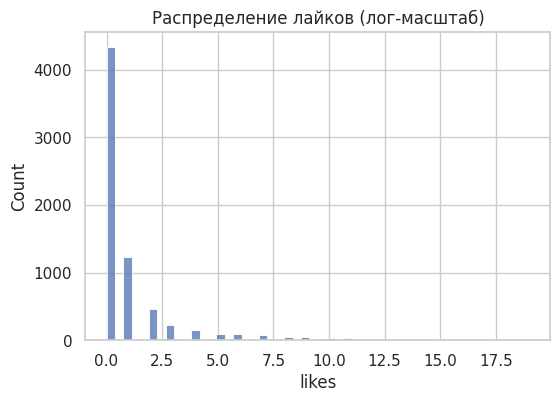

In [ ]:
plt.figure(figsize=(6,4))
sns.histplot(df_tweets[df_tweets["likes"] < 20]["likes"], bins=50)
plt.title("Распределение лайков (лог-масштаб)")
plt.show()

In [ ]:
df_tweets['label'].value_counts()

,count
label,
1,2810
2,1510
0,1418
4,952
5,592
3,39


In [ ]:
def remap_label(x):
    # Нейтральные
    if x in (0, 2, 4):
        # Нейтральные
        return 1
    elif x == 1:
        # Палестина
        return 0
    elif x in (3, 5):
        # Израиль
        return 2

In [ ]:
df_tweets['label_r'] = df_tweets['label'].apply(remap_label)

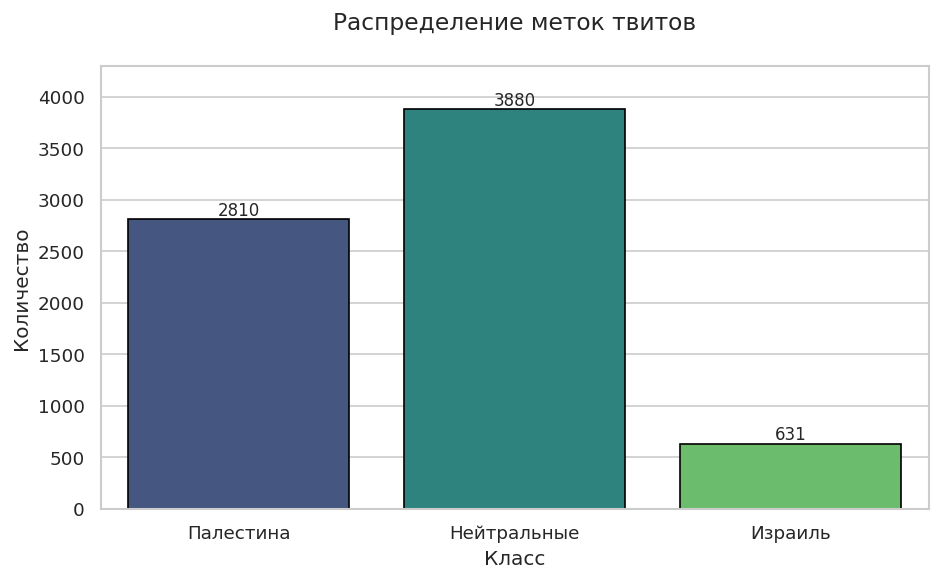

In [ ]:
label_counts = df_tweets['label_r'].value_counts().sort_index()
labels_map = {
    0: 'Палестина',
    1: 'Нейтральные',
    2: 'Израиль',
}
order = list(labels_map.keys())
labels = [labels_map[i] for i in order]

plt.figure(figsize=(8, 5), dpi=120)
bars = sns.barplot(
    x=order,
    y=label_counts.values,
    palette='viridis',
    edgecolor='black'
)

bars.set_xticklabels(labels)

for p in bars.patches:
    height = p.get_height()
    bars.annotate(
        f'{int(height)}',
        (p.get_x() + p.get_width() / 2, height),
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.title('Распределение меток твитов\n', fontsize=14)
plt.xlabel('Класс', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.ylim(top=4300)
plt.tight_layout()
plt.show()

## Выделение мнений

In [ ]:
umap_model = cuUMAP(
    n_neighbors=15,
    n_components=5,
    random_state=42
)

[2025-06-08 11:58:33.088] [CUML] [info] build_algo set to brute_force_knn because random_state is given


In [ ]:
texts = df_tweets['cleaned_text'].tolist()

embedding_model = SentenceTransformer(
    "all-MiniLM-L6-v2",
    device="cuda"
)
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=HDBSCAN(min_cluster_size=10),
    nr_topics="auto",
    low_memory=False,
    verbose=True
)


topics, probs = topic_model.fit_transform(texts)

df_tweets['topic'] = topics

topic_info = topic_model.get_topic_info()

topic_info = topic_info.sort_values('Count', ascending=False)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2025-06-08 11:58:43,027 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/229 [00:00<?, ?it/s]

2025-06-08 11:58:47,284 - BERTopic - Embedding - Completed ✓
2025-06-08 11:58:47,286 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-08 11:58:48,991 - BERTopic - Dimensionality - Completed ✓
2025-06-08 11:58:48,992 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-08 11:58:49,501 - BERTopic - Cluster - Completed ✓
2025-06-08 11:58:49,505 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-06-08 11:58:49,724 - BERTopic - Representation - Completed ✓
2025-06-08 11:58:49,725 - BERTopic - Topic reduction - Reducing number of topics
2025-06-08 11:58:49,741 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-06-08 11:58:49,877 - BERTopic - Representation - Completed ✓
2025-06-08 11:58:49,880 - BERTopic - Topic reduction - Reduced number of topics from 67 to 60


In [ ]:
fig1 = topic_model.visualize_topics()
fig1.show()

In [ ]:
fig2 = topic_model.visualize_barchart(top_n_topics=10, n_words=8)
fig2.show()

In [ ]:
fig3 = topic_model.visualize_heatmap()
fig3.show()

In [ ]:
fig4 = topic_model.visualize_hierarchy()
fig4.show()

In [ ]:
docs = df_tweets['cleaned_text'].tolist()
timestamps = df_tweets['datetime'].dt.to_pydatetime().tolist()
topics = df_tweets['topic'].tolist()

topics_over_time = topic_model.topics_over_time(
    docs,
    timestamps,
    topics,
    nr_bins=30
)

fig5 = topic_model.visualize_topics_over_time(
    topics_over_time,
    top_n_topics=10,
)
fig5.show()

10it [00:01,  8.78it/s]


## Анализ аффективной поляризации

### Поляризация корпуса

In [ ]:
texts_pos = df_tweets.loc[df_tweets['label_r']==0, 'cleaned_text']
texts_neg = df_tweets.loc[df_tweets['label_r']==2,'cleaned_text']

cnt_pos = Counter(" ".join(texts_pos).split())
cnt_neg = Counter(" ".join(texts_neg).split())
V = len(set(cnt_pos) | set(cnt_neg))
alpha = 1.0

def word_score(w):
    return np.log((cnt_pos[w]+alpha)/(sum(cnt_pos.values())+alpha*V)) \
         - np.log((cnt_neg[w]+alpha)/(sum(cnt_neg.values())+alpha*V))

def tweet_polarity(text):
    return sum(word_score(w) for w in text.split())

df_tweets['lex_polarity'] = df_tweets['cleaned_text'].progress_apply(tweet_polarity)

100%|██████████| 7321/7321 [00:20<00:00, 351.79it/s]


In [ ]:
df_tweets['lex_polarity'].describe()

,lex_polarity
count,7321.000000
mean,2.707787
std,10.564395
min,-346.547506
25%,-1.781736
50%,2.081803
75%,7.191424
max,441.874384


### Распределение категории в течении времени

In [ ]:
df = df_tweets.set_index('datetime').sort_index()

window = '7D'
roll = df.rolling(window=window, min_periods=1)

df_roll = pd.DataFrame({
    'mean_label':      roll['label'].mean(),
    'std_label':       roll['label'].std(),
    'extreme_ratio':   roll['label'].apply(lambda x: (x.abs()==1).mean()),
    'mean_lex_polarity': roll['lex_polarity'].mean(),
    'sum_likes':       roll['likes'].sum(),
    'sum_retweets':    roll['retweets'].sum(),
    'sum_quotes':      roll['quotes'].sum(),
    'sum_comments':    roll['comments'].sum(),
}).dropna()

X = df_roll.values
dates = df_roll.index

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

k = 3
km = KMeans(n_clusters=k, random_state=42).fit(X_scaled)
labels_km = km.labels_


sil_score = silhouette_score(X_scaled, labels_km)
print(f"Silhouette score: {sil_score:.3f}")

df_roll['cluster'] = labels_km
df_roll['pc1'], df_roll['pc2'] = X_pca.T

Silhouette score: 0.456


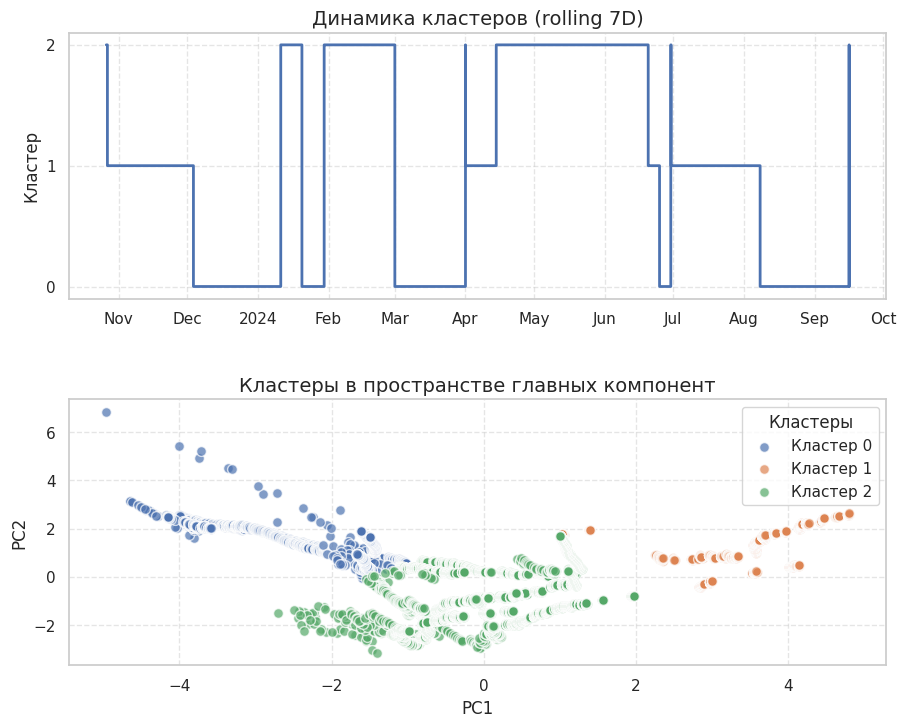

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=False)
fig.tight_layout(pad=4)

ax = axes[0]
ax.step(dates, labels_km, where='mid', linewidth=2)
ax.set_ylabel('Кластер', fontsize=12)
ax.set_title('Динамика кластеров (rolling 7D)', fontsize=14)
ax.set_yticks(range(k))
ax.grid(True, linestyle='--', alpha=0.5)

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

ax = axes[1]
for ci in range(k):
    mask = labels_km == ci
    ax.scatter(
        X_pca[mask, 0], X_pca[mask, 1],
        label=f'Кластер {ci}',
        s=50, alpha=0.7, edgecolor='w'
    )
ax.set_xlabel('PC1', fontsize=12)
ax.set_ylabel('PC2', fontsize=12)
ax.set_title('Кластеры в пространстве главных компонент', fontsize=14)
ax.legend(title='Кластеры')
ax.grid(True, linestyle='--', alpha=0.5)

plt.show()

### Авторегрессионная модель

In [ ]:
ts_daily = df_roll['mean_label'].resample('D').mean()
ts_daily = ts_daily.fillna(method='ffill')

In [ ]:
adf_stat, adf_p, *_ = adfuller(ts_daily)
if adf_p > 0.05:
    ts_for_ar = ts_daily.diff().dropna()
else:
    ts_for_ar = ts_daily.copy()

In [ ]:
res = arma_order_select_ic(ts_for_ar, max_ar=10, ic=['aic','bic'], trend='n')
p = res.aic_min_order[0]

In [ ]:
model = AutoReg(ts_daily, lags=p, old_names=False).fit()
print(model.summary())

                            AutoReg Model Results                             
Dep. Variable:             mean_label   No. Observations:                  327
Model:                     AutoReg(0)   Log Likelihood                 -40.753
Method:               Conditional MLE   S.D. of innovations              0.274
Date:                Sun, 08 Jun 2025   AIC                             85.505
Time:                        12:07:25   BIC                             93.085
Sample:                    10-26-2023   HQIC                            88.530
                         - 09-16-2024                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5714      0.015    103.676      0.000       1.542       1.601


In [ ]:
pred = model.predict(start=ts_daily.index[p], end=ts_daily.index[-1])
mse = ((ts_daily[p:] - pred[p:])**2).mean()
print(f"MSE = {mse:.5f}")

MSE = 0.07512


### Тест Грейнджера

In [ ]:
df_daily = (
    df
    .resample('D')
    .agg({
        'id':    'count',
        'label': 'mean'
    })
    .rename(columns={'id':'tweet_count','label':'pol_mean'})
)


onehot = pd.get_dummies(
    df['label'],
    prefix='roll_topic'
)
df_topic_daily = onehot.resample('D').mean()

df_daily = df_daily.join(df_topic_daily).fillna(0)

cols = ['pol_mean', 'tweet_count'] + [c for c in df_daily.columns if c.startswith('roll_topic_')]
df_gc = df_daily[cols].dropna()

In [ ]:
print("=== tweet_count -> pol_mean ===")
grangercausalitytests(df_gc[['pol_mean','tweet_count']], maxlag=7, verbose=True)

for topic_col in [c for c in df_gc.columns if c.startswith('roll_topic_')]:
    print(f"\n=== {topic_col} -> pol_mean ===")
    result = grangercausalitytests(df_gc[['pol_mean', topic_col]], maxlag=7, verbose=False)
    for lag, res in result.items():
        pval = res[0]['ssr_ftest'][1]
        print(f"lag={lag:>2}, p-value={pval:.3f}")

=== tweet_count -> pol_mean ===

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=109.2008, p=0.0000  , df_denom=323, df_num=1
ssr based chi2 test:   chi2=110.2151, p=0.0000  , df=1
likelihood ratio test: chi2=94.9436 , p=0.0000  , df=1
parameter F test:         F=109.2008, p=0.0000  , df_denom=323, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=58.1410 , p=0.0000  , df_denom=320, df_num=2
ssr based chi2 test:   chi2=118.0990, p=0.0000  , df=2
likelihood ratio test: chi2=100.7396, p=0.0000  , df=2
parameter F test:         F=58.1410 , p=0.0000  , df_denom=320, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=35.0126 , p=0.0000  , df_denom=317, df_num=3
ssr based chi2 test:   chi2=107.3572, p=0.0000  , df=3
likelihood ratio test: chi2=92.7265 , p=0.0000  , df=3
parameter F test:         F=35.0126 , p=0.0000  , df_denom=317, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test

### VAR

In [ ]:
topic_cols = [c for c in df_daily.columns if c.startswith('roll_topic_')]
top3 = (df_daily[topic_cols].mean().sort_values(ascending=False)
        .head(3).index.tolist())

model_df = df_daily[['pol_mean', 'tweet_count'] + top3].copy()

model_df_diff = model_df.diff().dropna()

In [ ]:
maxlags = 10
sel = VAR(model_df_diff).select_order(maxlags)
p = sel.aic
print(sel.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -11.12      -11.06   1.480e-05      -11.10
1       -12.87      -12.51   2.584e-06      -12.72
2       -13.30      -12.64   1.678e-06      -13.04
3       -13.87     -12.92*   9.438e-07      -13.49
4       -14.01      -12.77   8.204e-07     -13.52*
5       -14.05      -12.50   7.942e-07      -13.43
6       -14.03      -12.19   8.070e-07      -13.30
7       -13.99      -11.85   8.421e-07      -13.14
8       -14.02      -11.59   8.186e-07      -13.05
9       -14.21      -11.48   6.801e-07      -13.12
10     -14.31*      -11.28  6.205e-07*      -13.10
--------------------------------------------------


In [ ]:
var = VAR(model_df_diff)
res = var.fit(p)
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 08, Jun, 2025
Time:                     12:07:26
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -11.2763
Nobs:                     316.000    HQIC:                  -13.0963
Log likelihood:           273.588    FPE:                6.20466e-07
AIC:                     -14.3070    Det(Omega_mle):     2.93645e-07
--------------------------------------------------------------------
Results for equation pol_mean
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    0.008043         0.016756            0.480           0.631
L1.pol_mean              0.561342         0.423462            1.326           0.185
L1.tweet_count          -0.002702         0.0

In [ ]:
irf = res.irf(10)

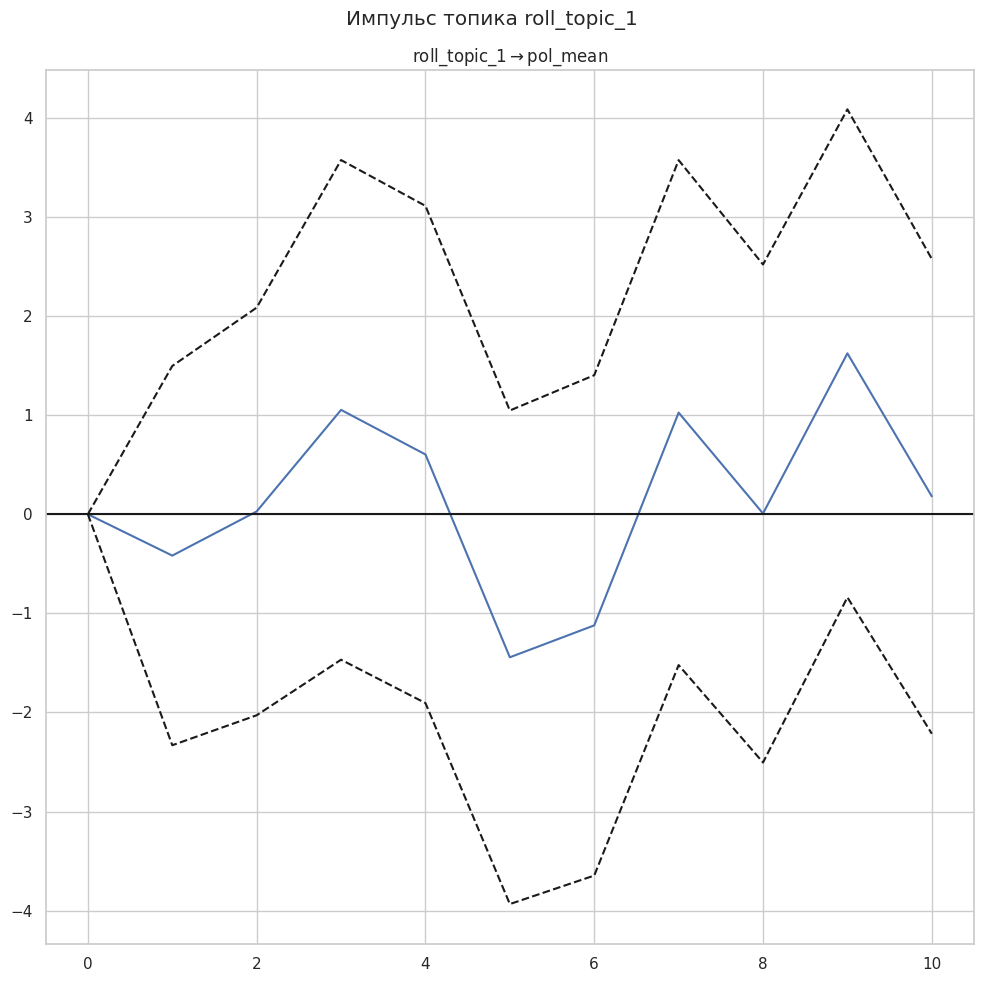

In [ ]:
fig = irf.plot(impulse=top3[0], response='pol_mean')
plt.suptitle(f"Импульс топика {top3[0]}")
plt.tight_layout()
plt.show()

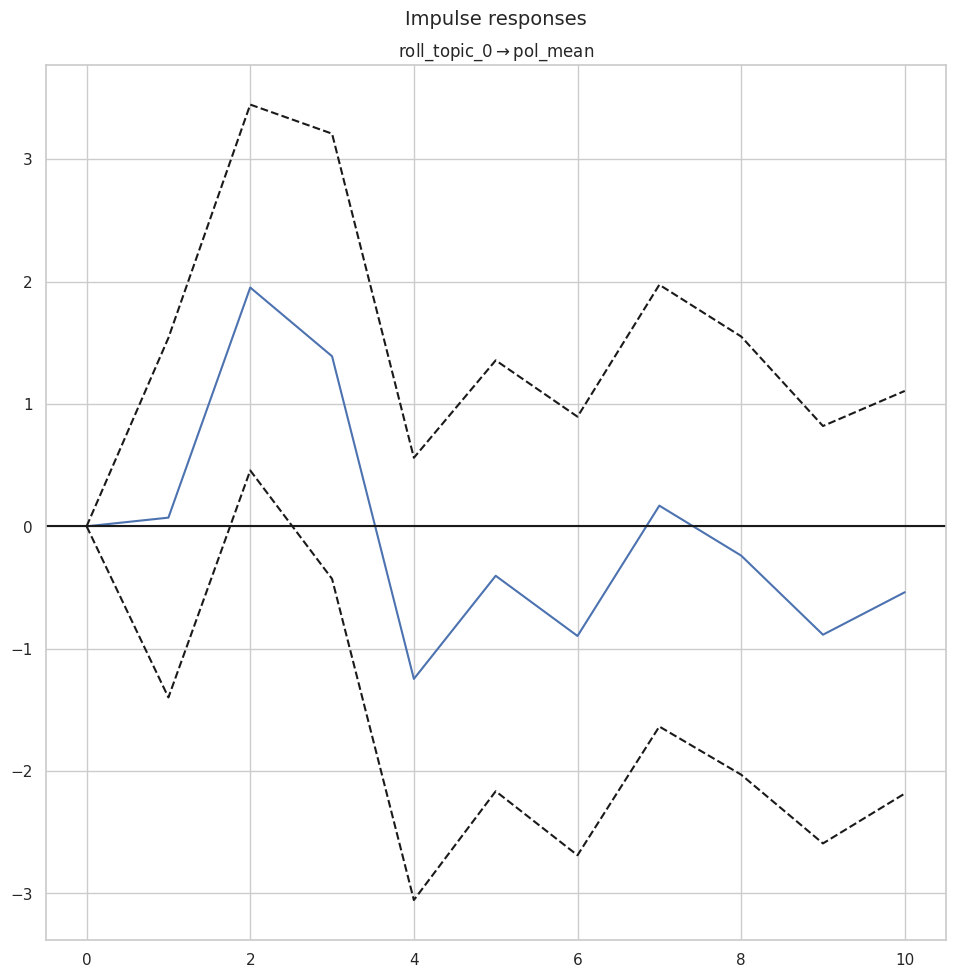

In [ ]:
irf.plot(impulse='roll_topic_0', response='pol_mean')
plt.show()

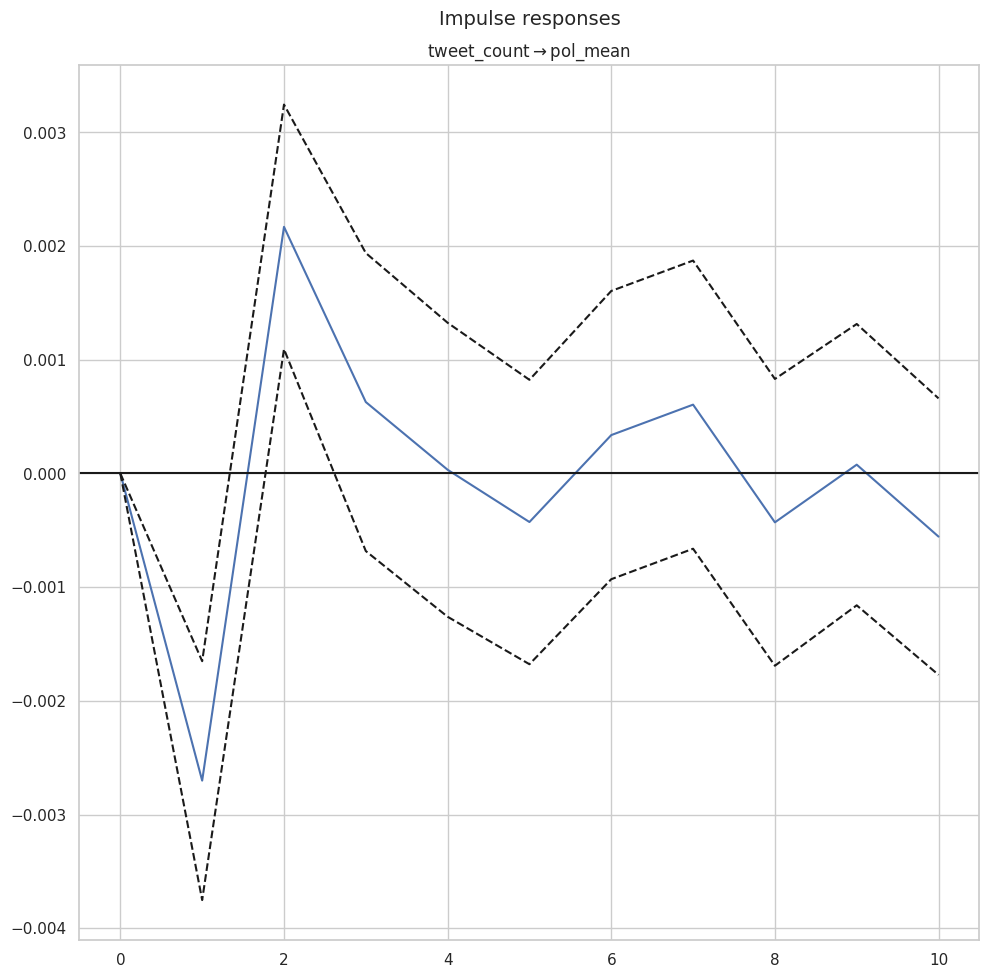

In [ ]:
irf.plot(impulse='tweet_count', response='pol_mean')
plt.show()